# MLP baseline

In this notebook, we use a basic MLP as a baseline for time series predictions, Here, we use the features as the previous 4 hours in the sequence and next time step is the label. We only used the time series data here, we don't include other data like weather or holidays in the training


In [1]:
import numpy as np

In [2]:
"""The Data is taken from the following repository"""
!git clone https://github.com/liulingbo918/ATFM.git

Cloning into 'ATFM'...
remote: Enumerating objects: 83, done.
remote: Total 83 (delta 0), reused 0 (delta 0), pack-reused 83
Unpacking objects: 100% (83/83), 20.94 MiB | 5.64 MiB/s, done.


In [3]:
"""The data consists of 3 components: in/outflow and Holidays and weather data"""
!ls ./ATFM/data/TaxiNYC/

Holiday.txt  Meteorology.h5  NYC2014.h5  README.md


In [4]:
import h5py

def read_h5(filename):
    data = {}
    with h5py.File(filename, "r") as f:
        # List all groups
        a_group_key = list(f.keys())
        # Get the data
        for key in a_group_key:
            data[key] = list(f[key])
    return data

In [5]:
"""read flow data"""
flow_dir = "./ATFM/data/TaxiNYC/NYC2014.h5"
data = read_h5(flow_dir)
timeslot_data = np.array(data['date'])
flow_data = np.array(data['data'])

flow_data.shape, timeslot_data.shape

((17520, 2, 15, 5), (17520,))

The data is inflow and outflow matrices in NYC

- data shape: (17520, 2, 15, 5)
- number of timeslots: 17520
- grid size: 15x5

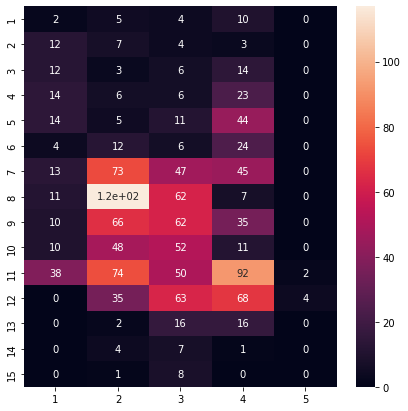

In [6]:
"""Amount of inflow in a certain time slice"""
import matplotlib.pyplot as plt
import seaborn as sns

one_time_slice_inflow = flow_data[100, 0, :, :]

x_axis_labels = range(1,6)
y_axis_labels = range(1,16)
plt.figure(figsize=(7,7))
ax = sns.heatmap(one_time_slice_inflow,xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True)
plt.show()

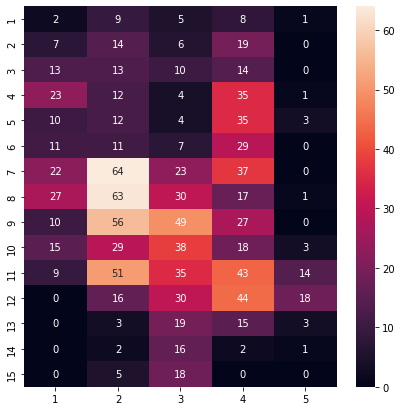

In [7]:
"""Amount of outflow in a certain time slice"""
one_time_slice_outflow = flow_data[100, 1, :, :]

plt.figure(figsize=(7,7))
ax = sns.heatmap(one_time_slice_outflow,xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True)
plt.show()

In [8]:
"""Standardize the data"""
mean = np.mean(flow_data)
std = np.std(flow_data)

flow_data_std = (flow_data-mean)/std

In [9]:
# history_length is timestep of the historical window size
# predict_length is the prediction horizon
def buid_data(data, x_len, y_len):
    x = []
    y = []
    length = data.shape[0]
    for end_idx in range(x_len + y_len, length):
        xtime = data[end_idx-y_len-x_len:end_idx-y_len]
        ytime = data[end_idx-y_len:end_idx]
        x.append(xtime)
        y.append(ytime)
    x = np.stack(x)
    y = np.stack(y)
    return x, y

In [10]:
"""Build data and train test split"""
x_len = 4 * 2  # 4 hours X 2 (data recorded each 30minutes)
y_len = 1  # next step
x, y = buid_data(flow_data_std, x_len, y_len)
print(x.shape)
print(y.shape)

xtrain = x[:12279]
ytrain = y[:12279]

xval = x[12279:13479]
yval = y[12279:13479]

xtest = x[13479:]
ytest = y[13479:]

xtrain = xtrain.reshape(xtrain.shape[0], -1)
ytrain = ytrain.reshape(ytrain.shape[0], -1)
xval = xval.reshape(xval.shape[0], -1)
yval = yval.reshape(yval.shape[0], -1)
xtest = xtest.reshape(xtest.shape[0], -1)
ytest = ytest.reshape(ytest.shape[0], -1)
print(xtrain.shape, ytrain.shape)

(17511, 8, 2, 15, 5)
(17511, 1, 2, 15, 5)
(12279, 1200) (12279, 150)


In [41]:
import torch
from torch import nn

class mlp(nn.Module):
    def __init__(self):
        super(mlp, self).__init__()
        #self.flatten = nn.Flatten()
        self.relu_stack = nn.Sequential(
            nn.Linear(in_features=1200, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=150),
        )

    def forward(self, x):
        #x = self.flatten(x)
        logits = self.relu_stack(x)
        return logits

In [48]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = mlp().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [34]:
xtrain = torch.Tensor(xtrain).to(device)
ytrain = torch.Tensor(ytrain).to(device)
xval = torch.Tensor(xval).to(device)
yval = torch.Tensor(yval).to(device)
xtest = torch.Tensor(xtest).to(device)
ytest = torch.Tensor(ytest).to(device)

batch_size = 32
train_data = torch.utils.data.TensorDataset(xtrain, ytrain)
train_iter = torch.utils.data.DataLoader(train_data, batch_size)
val_data = torch.utils.data.TensorDataset(xtest, ytest)
val_iter = torch.utils.data.DataLoader(val_data, batch_size)
test_data = torch.utils.data.TensorDataset(xtest, ytest)
test_iter = torch.utils.data.DataLoader(test_data, batch_size)

In [36]:
"""Validation loop"""
def validate(model):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in val_iter:
            outputs = model(x)
            loss = loss_fn(outputs.cpu(), y.cpu())
            losses.append(loss)
    mean_loss = np.mean(losses)
    return mean_loss

In [51]:
"""Train loop"""
NUM_EPOCHS = 50

for epoch in range(NUM_EPOCHS):
    losses = []
    
    for x, y in train_iter:
        outputs = model(x)
        loss = loss_fn(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    train_loss = np.mean(losses)
    val_loss = validate(model) 
    
    if epoch % 5 == 0:
        print('Epoch: ', epoch+1, ', Train Loss: ', train_loss, ', Val Loss: ', val_loss)

Epoch:  1 , Train Loss:  0.04566569463834943 , Val Loss:  0.04138994
Epoch:  6 , Train Loss:  0.03282003284645422 , Val Loss:  0.03285017
Epoch:  11 , Train Loss:  0.02756429550451382 , Val Loss:  0.03075796
Epoch:  16 , Train Loss:  0.025341177815183375 , Val Loss:  0.030263564
Epoch:  21 , Train Loss:  0.022258458445624758 , Val Loss:  0.028918644
Epoch:  26 , Train Loss:  0.026992429372815725 , Val Loss:  0.03009139
Epoch:  31 , Train Loss:  0.020881469596740015 , Val Loss:  0.02768689
Epoch:  36 , Train Loss:  0.020101531842859306 , Val Loss:  0.027934946
Epoch:  41 , Train Loss:  0.018770260857612204 , Val Loss:  0.027247272
Epoch:  46 , Train Loss:  0.01825389793278494 , Val Loss:  0.02679423


In [52]:
"""Test data predictions"""
model.eval()
y_preds = list()
y_true = list()

with torch.no_grad():
    for x, y in test_iter:
        y = y.cpu().numpy().reshape(-1)
        y_pred = model(x).view(len(y), -1).cpu().numpy().reshape(-1)
        y = y * std + mean
        y_pred = y_pred* std + mean
        y_preds.extend(list(y_pred))
        y_true.extend(list(y))
        
y_preds = np.array(y_preds)
y_true = np.array(y_true)

In [53]:
"""Overall evaluation the predictions of the test data"""
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import numpy as np

def smape(true, preds):
    mape = np.abs(preds - true) / (np.abs(true) + np.abs(preds))
    return 100/len(true) * np.sum(2 * mape)

print('RMSE: ', np.sqrt(mean_squared_error(y_true.flatten(), y_preds.flatten())))
print('MAE: ', mean_absolute_error(y_true.flatten(), y_preds.flatten()))
print('sMAPE: ', smape(y_true.flatten(), y_preds.flatten()), "%")

RMSE:  25.096798
MAE:  13.501155
sMAPE:  44.94534350198413 %


In [54]:
test_preds = y_preds.reshape(4032,2, 15, 5)
test_true = y_true.reshape(4032, 2, 15, 5)

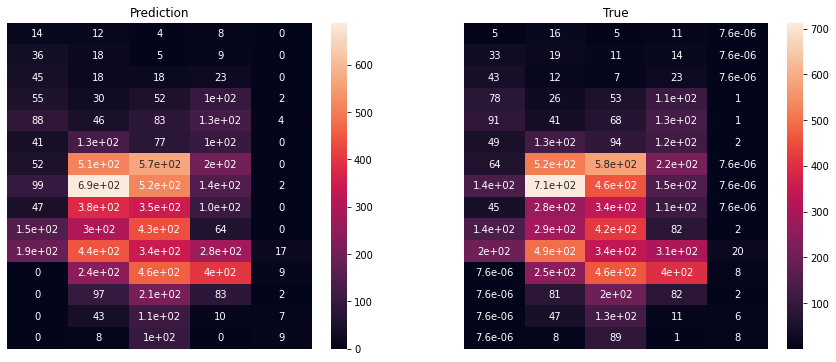

In [55]:
"""Prediction of inflow at certain time slice"""

import matplotlib.pyplot as plt
import seaborn as sns

one_time_slice_inflow_true = test_true[0, 0, :, :]
one_time_slice_inflow_preds = test_preds[0, 0, :, :]
one_time_slice_inflow_preds = one_time_slice_inflow_preds.astype(int)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

x_axis_labels = y_axis_labels = range(16,6)

sns.heatmap(one_time_slice_inflow_preds, 
                 xticklabels=x_axis_labels, 
                 yticklabels=y_axis_labels, 
                 ax=ax1, annot=True)

sns.heatmap(one_time_slice_inflow_true, 
                 xticklabels=x_axis_labels, 
                 yticklabels=y_axis_labels, 
                 ax=ax2, annot=True)

ax2.set_title('True')
ax1.set_title('Prediction')
plt.show()

# References:

- https://github.com/jwwthu/DL4Traffic

- https://github.com/liulingbo918/ATFM
